In [ ]:
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import Descriptors, AllChem
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import StratifiedKFold
import collections
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
import gc
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_auc_score
from sklearn.metrics import r2_score
from rdkit.Chem.rdmolfiles import MolFromSmiles
from rdkit.Chem.AllChem import GetMorganFingerprintAsBitVect
from rdkit.Chem import PandasTools
from sklearn.ensemble import RandomForestClassifier
from rdkit import DataStructs

In [ ]:
seed = 42

In [ ]:
# Function for getting molecular fingerprints
def calcfp(mol,funcFPInfo=dict(radius=3,nBits=2048,useFeatures=False,useChirality = False)):
    arr = np.zeros((1,))
    fp = GetMorganFingerprintAsBitVect(mol, **funcFPInfo)
    DataStructs.ConvertToNumpyArray(fp, arr)
    return arr

## ***Loading data***

In [ ]:
train = pd.read_excel('Train_with_smiles.xlsx')
valid = pd.read_excel('Valid_with_smiles.xlsx')
test = pd.read_excel('Test_with_smiles.xlsx')

data = pd.concat([train, test, valid], ignore_index=True)

cols = ['PUBCHEM_ACTIVITY_OUTCOME', 'smiles']
data = data[cols]
data = data.rename(columns={'PUBCHEM_ACTIVITY_OUTCOME': 'labels'})

label_map = {
    'Active': 1,
    'Inactive': 0,
}

data['labels'] = data['labels'].map(label_map)

In [ ]:
del train
del valid
del test
gc.collect()

41022

In [ ]:
train_df1, test_df1 = train_test_split(data, test_size=0.2, random_state = seed, stratify=data['labels'])
train_df1, valid_df1 = train_test_split(train_df1, test_size=0.2, random_state = seed,  stratify=train_df1['labels'])

## ***Balancing train data***

In [ ]:
majority_class = train_df1[train_df1['labels'] == 0]
minority_class = train_df1[train_df1['labels'] == 1]

majority_undersampled = resample(majority_class, replace=False, n_samples=len(minority_class), random_state = seed)

train_df1 = pd.concat([minority_class, majority_undersampled])

## ***Getting molecular fingerprints***

In [ ]:
# get RDKit molecule objects from smiles column
PandasTools.AddMoleculeColumnToFrame(train_df1, smilesCol='smiles', molCol='Mol', includeFingerprints=False)
moldf = train_df1[pd.notnull(train_df1['Mol'])]

[19:55:31] WARNING: not removing hydrogen atom without neighbors
[19:55:32] WARNING: not removing hydrogen atom without neighbors


In [ ]:
# add molecular fingerprint to the dataframe using the obtained RDKit molecule objects
moldf['Descriptors'] = moldf.Mol.apply(calcfp)
X = np.array(list(moldf['Descriptors'])).astype(int)
y = moldf['labels'].to_numpy()
X.shape

(38378, 2048)

## ***Random forest model***

In [ ]:
rf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
                       max_depth=None, max_features='sqrt', max_leaf_nodes=None,
                       min_impurity_decrease=0.0,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [ ]:
rf.fit(X, y)

RandomForestClassifier(criterion='entropy', n_estimators=500)

## Test evaluation

In [ ]:
PandasTools.AddMoleculeColumnToFrame(test_df1, smilesCol='smiles', molCol='Mol', includeFingerprints=False)
test = test_df1[pd.notnull(test_df1['Mol'])]

In [ ]:
test['Descriptors'] = test.Mol.apply(calcfp)
X = np.array(list(test['Descriptors'])).astype(int)
y = test['labels'].to_numpy()

In [ ]:
preds = rf.predict(X)
probs = rf.predict_proba(X)[:, 1]

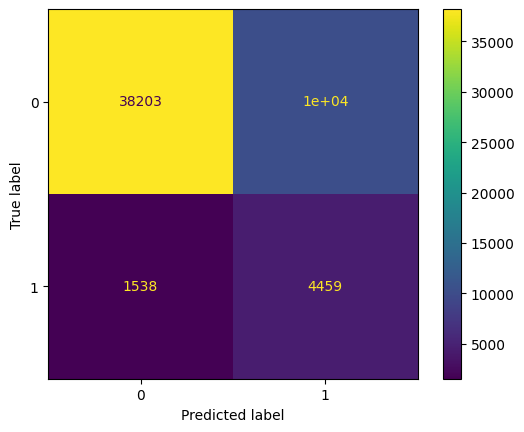

In [ ]:
cm = confusion_matrix(y, preds)
ConfusionMatrixDisplay(cm).plot()

In [ ]:
tn, fp, fn, tp = cm.ravel()

sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)
ccr = (specificity+ sensitivity)/2
ppv = (tp / (tp + fp))
npv = (tn / (tn + fn)) if (tn + fn) > 0 else 0

print('sen:{}'.format(sensitivity))
print('spe:{}'.format(specificity))
print('CCR:{}'.format(ccr))
print('ppv:{}'.format(ppv))
print('nen:{}'.format(npv))

sen:0.743538435884609
spe:0.7872686807072498
CCR:0.7654035582959293
ppv:0.30165065620349074
nen:0.9612994137037316


In [ ]:
# Calculate the AUC score
auc_score = roc_auc_score(y, probs)

print("AUC-ROC Score:", auc_score)

AUC-ROC Score: 0.838792276999619


## Ten runs:

In [ ]:
random_seed_list = [123, 80, 789, 567, 890, 345, 678, 901, 456, 12]

In [ ]:
def runs(random_seed_list, data):

  ccr_list = []
  sen_list = []
  spe_list = []
  ppv_list = []
  npv_list = []
  auc_list = []

  for seed in random_seed_list:

        train_df1, test_df1 = train_test_split(data, test_size=0.2, random_state = seed, stratify=data['labels'])
        train_df1, valid_df1 = train_test_split(train_df1, test_size=0.2, random_state = seed,  stratify=train_df1['labels'])

        train_df1 = train_df1.reset_index(drop=True)
        test_df1 = test_df1.reset_index(drop=True)

        #balance the traininng data
        majority_class = train_df1[train_df1['labels'] == 0]
        minority_class = train_df1[train_df1['labels'] == 1]
        majority_undersampled = resample(majority_class, replace=False, n_samples=len(minority_class), random_state = seed)
        train_df1 = pd.concat([minority_class, majority_undersampled])

        # preparing data for training
        PandasTools.AddMoleculeColumnToFrame(train_df1, smilesCol='smiles', molCol='Mol', includeFingerprints=False)
        PandasTools.AddMoleculeColumnToFrame(train_df1, smilesCol='smiles', molCol='Mol', includeFingerprints=False)
        moldf = train_df1[pd.notnull(train_df1['Mol'])]

        moldf['Descriptors'] = moldf.Mol.apply(calcfp)
        X = np.array(list(moldf['Descriptors'])).astype(int)
        y = moldf['labels'].to_numpy()

        # fit the model
        rf.fit(X,y)

        # prepare evaluation dataevaluation
        PandasTools.AddMoleculeColumnToFrame(test_df1, smilesCol='smiles', molCol='Mol', includeFingerprints=False)
        test = test_df1[pd.notnull(test_df1['Mol'])]

        test['Descriptors'] = test.Mol.apply(calcfp)
        X = np.array(list(test['Descriptors'])).astype(int)
        y = test['labels'].to_numpy()

        #predict and evaluate
        preds = rf.predict(X)
        probs = rf.predict_proba(X)[:, 1]

        cm = confusion_matrix(y, preds)
        tn, fp, fn, tp = cm.ravel()

        sensitivity = tp / (tp + fn)
        specificity = tn / (tn + fp)
        ccr = (specificity+ sensitivity)/2
        ppv = (tp / (tp + fp))
        npv = (tn / (tn + fn))

        auc_score = roc_auc_score(y, probs)

        ccr_list.append(ccr)
        sen_list.append(sensitivity)
        spe_list.append(specificity)
        ppv_list.append(ppv)
        npv_list.append(npv)
        auc_list.append(auc_score)

        print('finished run:', len(ccr_list))

  return ccr_list, sen_list, spe_list, ppv_list, npv_list, auc_list

In [ ]:
ccr_list, sen_list, spe_list, ppv_list, npv_list, auc_list = runs(random_seed_list, data)

[19:59:38] WARNING: not removing hydrogen atom without neighbors
[19:59:44] WARNING: not removing hydrogen atom without neighbors
[20:03:06] WARNING: not removing hydrogen atom without neighbors


finished run: 1


[20:03:49] WARNING: not removing hydrogen atom without neighbors
[20:03:54] WARNING: not removing hydrogen atom without neighbors


finished run: 2


[20:08:02] WARNING: not removing hydrogen atom without neighbors
[20:08:07] WARNING: not removing hydrogen atom without neighbors
[20:11:21] WARNING: not removing hydrogen atom without neighbors


finished run: 3


[20:12:11] WARNING: not removing hydrogen atom without neighbors
[20:12:16] WARNING: not removing hydrogen atom without neighbors
[20:15:34] WARNING: not removing hydrogen atom without neighbors


finished run: 4


[20:16:19] WARNING: not removing hydrogen atom without neighbors
[20:16:21] WARNING: not removing hydrogen atom without neighbors
[20:16:24] WARNING: not removing hydrogen atom without neighbors
[20:16:26] WARNING: not removing hydrogen atom without neighbors


finished run: 5


[20:20:28] WARNING: not removing hydrogen atom without neighbors
[20:20:33] WARNING: not removing hydrogen atom without neighbors
[20:23:51] WARNING: not removing hydrogen atom without neighbors


finished run: 6


[20:24:37] WARNING: not removing hydrogen atom without neighbors
[20:24:37] WARNING: not removing hydrogen atom without neighbors
[20:24:42] WARNING: not removing hydrogen atom without neighbors
[20:24:42] WARNING: not removing hydrogen atom without neighbors


finished run: 7


[20:28:45] WARNING: not removing hydrogen atom without neighbors
[20:28:46] WARNING: not removing hydrogen atom without neighbors
[20:28:50] WARNING: not removing hydrogen atom without neighbors
[20:28:51] WARNING: not removing hydrogen atom without neighbors


finished run: 8


[20:32:53] WARNING: not removing hydrogen atom without neighbors
[20:32:58] WARNING: not removing hydrogen atom without neighbors


finished run: 9


[20:37:01] WARNING: not removing hydrogen atom without neighbors
[20:37:02] WARNING: not removing hydrogen atom without neighbors
[20:37:06] WARNING: not removing hydrogen atom without neighbors
[20:37:07] WARNING: not removing hydrogen atom without neighbors


finished run: 10


In [ ]:
# Calculate mean and standard deviation
ccr_mean = np.mean(ccr_list)
ccr_std = np.std(ccr_list)

sen_mean = np.mean(sen_list)
sen_std = np.std(sen_list)

spe_mean = np.mean(spe_list)
spe_std = np.std(spe_list)

ppv_mean = np.mean(ppv_list)
ppv_std = np.std(ppv_list)

npv_mean = np.mean(npv_list)
npv_std = np.std(npv_list)

auc_mean = np.mean(auc_list)
auc_std = np.std(auc_list)

# Print the results
print(f'Mean and Standard Deviation of CCR: {ccr_mean:.2f} ± {ccr_std:.2f}')
print(f'Mean and Standard Deviation of Sensitivity: {sen_mean:.2f} ± {sen_std:.2f}')
print(f'Mean and Standard Deviation of Specificity: {spe_mean:.2f} ± {spe_std:.2f}')
print(f'Mean and Standard Deviation of PPV: {ppv_mean:.2f} ± {ppv_std:.2f}')
print(f'Mean and Standard Deviation of NPV: {npv_mean:.2f} ± {npv_std:.2f}')
print(f'Mean and Standard Deviation of AUC: {auc_mean:.2f} ± {auc_std:.2f}')

Mean and Standard Deviation of CCR: 0.76 ± 0.00
Mean and Standard Deviation of Sensitivity: 0.74 ± 0.00
Mean and Standard Deviation of Specificity: 0.79 ± 0.00
Mean and Standard Deviation of PPV: 0.30 ± 0.00
Mean and Standard Deviation of NPV: 0.96 ± 0.00
Mean and Standard Deviation of AUC: 0.83 ± 0.00
